In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = '4'
import gc
import cv2

import numpy as np
import joblib

from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import albumentations as A
from IPython.display import display
from PIL import Image


In [ ]:
# ======================
# Configuration
# ======================
TARGET_SIZE = (128, 128)
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)
COLOR_BINS = 64  # Increased from 32
SIFT_CLUSTERS = 50
SEGMENT_MIN_SIZE = 128  # Minimum size for recursive segmentation
MAX_RECURSION_DEPTH = 4  # Maximum recursion depth

# Toggle PCA usage. (Sometimes disabling PCA helps when using handcrafted features.)
USE_PCA = False  # Try setting to False if needed
# Toggle SIFT
USE_SIFT = True
# Adjust the threshold probability for multi-class predictions during inference.
THRESHOLD_PROB = 0.10  # Lowering from 0.2 may yield more detections
# Toggle Image Augmentation
USE_AUG = True
# Toggle Model Training
USE_TRAIN = True

# Toggle hyperparameter tuning
DO_HYPERPARAMETER_TUNING = False

# Path configurations
POKEMON_DIR = 'pokemon-data'
NO_POKEMON_DIR = 'no-pokemon'
MODEL_SAVE_DIR = 'models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Data Augmentation Pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.5),
    A.Resize(height=TARGET_SIZE[0], width=TARGET_SIZE[1])
])

In [63]:
def transform_image(img, target_size=TARGET_SIZE):
    """
    Reads an image from disk, ensures it is 8-bit RGB, and resizes it to the target size.
    This function should be used during both training and inference.
    """
    if img is None:
        return None
    
    if img.dtype != np.uint8:
        img = cv2.convertScaleAbs(img)
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the image

    img = cv2.resize(img, target_size)
    return img

def load_images(path, target_size=TARGET_SIZE):
    images = []
    for fname in os.listdir(path):
        img_path = os.path.join(path, fname)
        # Read image with unchanged flag to capture any alpha channels or unusual bit depths
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img = transform_image(img)
        if img is not None:
            if USE_AUG:
                augmented = transform(image=img)
                augmented_img = augmented['image']
                images.append(augmented_img)      
            images.append(img)
    return images

In [64]:
# ======================
# Load and Transform Images for each class
# ======================
# Binary data: positive (pokemon) vs. negative (no pokemon)
pokemon_images = []
for pname in os.listdir(POKEMON_DIR):
    pokemon_images += load_images(os.path.join(POKEMON_DIR, pname))
no_pokemon_images = load_images(NO_POKEMON_DIR)
# Multi-class data: labels for individual pokemon
multi_images = []
multi_labels = []
for pname in os.listdir(POKEMON_DIR):
    imgs = load_images(os.path.join(POKEMON_DIR, pname))
    multi_images += imgs
    multi_labels += [pname] * len(imgs)

3180


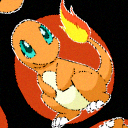

In [65]:
print(len(multi_images))
display(Image.fromarray(multi_images[1000]))

In [66]:
# ======================
# Feature Extraction
# ======================
class FeatureExtractor:
    def __init__(self, sift_kmeans=None):
        if USE_SIFT:
            self.sift = cv2.SIFT_create()
            self.kmeans = sift_kmeans
        self.scaler_bin = StandardScaler()
        self.scaler_multi = StandardScaler()

    def extract_basic_features(self, img):
        """Enhanced color-aware feature extraction"""
        # Convert image to grayscale for HOG and LBP
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # --- HOG Features (Grayscale) ---
        hog_features = hog(
            gray,
            orientations=HOG_ORIENTATIONS,
            pixels_per_cell=HOG_PIXELS_PER_CELL,
            cells_per_block=HOG_CELLS_PER_BLOCK,
            block_norm='L2-Hys'
        )
        # Note: Instead of computing HOG on each color channel, we use the grayscale image.

        # --- LBP Features (Grayscale) ---
        # Compute LBP on the grayscale image
        P = 8  # Number of circularly symmetric neighbor set points
        R = 1  # Radius
        n_bins_lbp = P + 2  # For uniform patterns
        lbp = local_binary_pattern(gray, P=P, R=R, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins_lbp, range=(0, n_bins_lbp))
        lbp_features = hist.astype('float')
        lbp_features /= (lbp_features.sum() + 1e-7)
        
        # --- Color Histograms ---
        # Compute histograms in both HSV and LAB color spaces.
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        color_features = []
        # HSV histograms:
        h_hist, _ = np.histogram(hsv[:, :, 0].ravel(), bins=COLOR_BINS, range=(0, 180))
        s_hist, _ = np.histogram(hsv[:, :, 1].ravel(), bins=COLOR_BINS, range=(0, 256))
        v_hist, _ = np.histogram(hsv[:, :, 2].ravel(), bins=COLOR_BINS, range=(0, 256))
        h_hist = h_hist.astype('float') / (h_hist.sum() + 1e-7)
        s_hist = s_hist.astype('float') / (s_hist.sum() + 1e-7)
        v_hist = v_hist.astype('float') / (v_hist.sum() + 1e-7)
        color_features.extend([h_hist, s_hist, v_hist])
        # LAB histograms:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        for channel in range(3):
            lab_hist, _ = np.histogram(lab[:, :, channel].ravel(), bins=COLOR_BINS, range=(0, 256))
            lab_hist = lab_hist.astype('float') / (lab_hist.sum() + 1e-7)
            color_features.append(lab_hist)
        color_features = np.concatenate(color_features)
        
        # --- Final Feature Vector ---
        return np.concatenate([hog_features, lbp_features, color_features])

    def extract_sift_features(self, img):
        """Color-enhanced SIFT using dominant color channel.
           Note: Consider using a dense sampling strategy if keypoint detection is too sparse.
        """
        variances = [np.var(img[:, :, i]) for i in range(3)]
        dominant_channel = np.argmax(variances)
        _, des = self.sift.detectAndCompute(img[:, :, dominant_channel], None)
        if des is None or len(des) < 5:
            return np.zeros(SIFT_CLUSTERS)
        clusters = self.kmeans.predict(des)
        return np.bincount(clusters, minlength=SIFT_CLUSTERS)

    def extract_all_features(self, img):
        basic = self.extract_basic_features(img)
        if USE_SIFT:
            sift = self.extract_sift_features(img)
            return np.hstack([basic, sift])
        return np.hstack([basic])


In [67]:
# ======================
# Training Pipeline
# ======================
def train_sift_codebook(images):
    sift = cv2.SIFT_create()
    descriptors = []
    
    for img in images:
        variances = [np.var(img[:, :, i]) for i in range(3)]
        dominant_channel = np.argmax(variances)
        _, des = sift.detectAndCompute(img[:, :, dominant_channel], None)
        if des is not None:
            descriptors.append(des)
    
    if len(descriptors) == 0:
        raise ValueError("No SIFT descriptors found in any image!")
    
    all_descriptors = np.vstack(descriptors)
    kmeans = MiniBatchKMeans(n_clusters=SIFT_CLUSTERS, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans

if USE_TRAIN:
    if USE_SIFT:
        print("Training SIFT codebook...")
        sift_kmeans = train_sift_codebook(multi_images)
        joblib.dump(sift_kmeans, os.path.join(MODEL_SAVE_DIR, 'sift_kmeans.pkl'))
                # Initialize feature extractor        
        fe = FeatureExtractor(sift_kmeans)
    else:
        fe = FeatureExtractor()

Training SIFT codebook...


c:\Users\i.kasionis\AppData\Local\anaconda3\envs\msc\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2560 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [68]:
# ======================
# Feature Extraction for Multi-class Classification
# ======================
if USE_TRAIN:
    print("\nTraining multi-class classifiers...")
    le = LabelEncoder()
    y_multi = le.fit_transform(multi_labels)
        
    print("Extracting features...")
    X_multi = [fe.extract_all_features(img) for img in tqdm(multi_images, desc='Processing images')]
    X_multi = fe.scaler_multi.fit_transform(X_multi)
    X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.2, stratify=y_multi, random_state=42)

    pca_multi = None
    if USE_PCA:
        pca_multi = PCA(n_components=0.95, random_state=42)
        X_train_multi = pca_multi.fit_transform(X_train_multi)
        X_test_multi = pca_multi.transform(X_test_multi)
        joblib.dump(pca_multi, os.path.join(MODEL_SAVE_DIR, 'pca_multi.pkl'))

In [69]:
if USE_TRAIN:
    # Define multi-class models along with their parameter grids.
    models = {
    #'XGBoost': (XGBClassifier(random_state=42), {
    #    'n_estimators': [50],
    #    'learning_rate': [0.1],
    #    'max_depth': [3]
    #}),
    #'SVM-RBF': (SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'), {
    #    'C': [1],
    #    'gamma': ['scale']
    #}),
    #'kNN': (KNeighborsClassifier(weights='distance'), {
    #    'n_neighbors': [5],
    #    'weights': ['uniform']
    #}),
    'RForest': (RandomForestClassifier(random_state=42, class_weight='balanced'), {
        'n_estimators': [100],
        'max_depth': [None],
        'min_samples_split': [2],
        'min_samples_leaf': [4],
        'max_features': [None],
        'n_jobs': [-1],
        'class_weight': ["balanced"],
        'verbose': [1]
    })
    }
    for model_name, (model, param_grid) in models.items():
        if DO_HYPERPARAMETER_TUNING:
            print(f"\nTuning {model_name}...")
            grid = GridSearchCV(
                model, param_grid, cv=3, scoring='accuracy', n_jobs=4, verbose=2
            )
            grid.fit(X_train_multi, y_train_multi)
            print(f"Best parameters for {model_name}:", grid.best_params_)
            best_model = grid.best_estimator_
        else:
            best_model = model.fit(X_train_multi, y_train_multi)
        
        y_pred = best_model.predict(X_test_multi)
        print(f"\n{model_name} Performance:")
        print(classification_report(le.inverse_transform(y_test_multi), 
                                    le.inverse_transform(y_pred)))
        
        joblib.dump(best_model, os.path.join(MODEL_SAVE_DIR, f'multi_clf_{model_name.lower()}.pkl'))

    joblib.dump(fe.scaler_multi, os.path.join(MODEL_SAVE_DIR, 'scaler_multi.pkl'))
    joblib.dump(le, os.path.join(MODEL_SAVE_DIR, 'label_encoder.pkl'))
        
    print("\nTraining complete! Models saved to:", MODEL_SAVE_DIR)

In [70]:
# ======================
# Inference Pipeline
# ======================
class PokemonDetector:
    def __init__(self, model_name='rforest'):
        if USE_SIFT:
            self.sift_kmeans = joblib.load(os.path.join(MODEL_SAVE_DIR, 'sift_kmeans.pkl'))
            self.fe = FeatureExtractor(self.sift_kmeans)
        else:
            self.fe = FeatureExtractor()
        self.binary_clf = joblib.load(os.path.join(MODEL_SAVE_DIR, 'binary_clf.pkl'))
        self.multi_clf = joblib.load(os.path.join(MODEL_SAVE_DIR, f'multi_clf_{model_name.lower()}.pkl'))
        self.le = joblib.load(os.path.join(MODEL_SAVE_DIR, 'label_encoder.pkl'))
        self.scaler_bin = joblib.load(os.path.join(MODEL_SAVE_DIR, 'scaler_bin.pkl'))
        self.scaler_multi = joblib.load(os.path.join(MODEL_SAVE_DIR, 'scaler_multi.pkl'))
        
        self.use_pca = USE_PCA
        if self.use_pca:
            self.pca_bin = joblib.load(os.path.join(MODEL_SAVE_DIR, 'pca_bin.pkl'))
            self.pca_multi = joblib.load(os.path.join(MODEL_SAVE_DIR, 'pca_multi.pkl'))
    
    def predict(self, image_path):
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            return []
        predictions = []

        img_resized = transform_image(img)
        features = self.fe.extract_all_features(img_resized)
        features = self.scaler_multi.transform([features])
        if self.use_pca:
                features = self.pca_multi.transform(features)
        
        pred_probs = self.multi_clf.predict_proba(features)[0]
        pred = np.argmax(pred_probs)
        
        class_labels = self.le.inverse_transform(np.arange(len(pred_probs)))  # Get class labels
        for label, prob in zip(class_labels, pred_probs):
            print(f"Class: {label}, Probability: {prob:.4f}")
        
        
        prediction = self.le.inverse_transform([pred])[0]
        predictions.append(prediction)

        print(prediction, pred_probs[pred])
        display(Image.fromarray(img_resized))
        
        return list(set(predictions))
    
    def predict_multi(self, image_path, filter_positive_tiles=None, recursive_tiling=None):
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            return []
        
        all_tiles = recursive_tiling(img)
        
        candidate_tiles = all_tiles
        candidate_tiles = filter_positive_tiles(
            all_tiles, self.binary_clf, self.fe, self.scaler_bin,
            pca=self.pca_bin if self.use_pca else None
        )
        # Further filter tiles that are too small
        candidate_tiles = [t for t in candidate_tiles if t.shape[0] >= SEGMENT_MIN_SIZE and t.shape[1] >= SEGMENT_MIN_SIZE]
        predictions = []
        for tile in candidate_tiles:
            tile_resized = transform_image(tile)
            features = self.fe.extract_all_features(tile_resized)
            features = self.scaler_multi.transform([features])
            if self.use_pca:
                features = self.pca_multi.transform(features)
            
            pred_probs = self.multi_clf.predict_proba(features)[0]
            pred = np.argmax(pred_probs)
            
            class_labels = self.le.inverse_transform(np.arange(len(pred_probs)))  # Get class labels
    
            #for label, prob in zip(class_labels, pred_probs):
                #print(f"Class: {label}, Probability: {prob:.4f}")

            if pred_probs[pred] >= THRESHOLD_PROB:
                prediction = self.le.inverse_transform([pred])[0]
                predictions.append(prediction)
                #print(prediction, pred_probs[pred])
                #plt.figure()
                #plt.imshow(tile_resized)
                #plt.show()
        
        return list(set(predictions))

Class: Blastoise, Probability: 0.0600
Class: Bulbasaur, Probability: 0.0500
Class: Charizard, Probability: 0.0800
Class: Charmander, Probability: 0.1100
Class: Charmeleon, Probability: 0.1000
Class: Ivysaur, Probability: 0.0500
Class: Pikachu, Probability: 0.1000
Class: Raichu, Probability: 0.3100
Class: Squirtle, Probability: 0.0500
Class: Venusaur, Probability: 0.0600
Class: Wartortle, Probability: 0.0300
Raichu 0.31


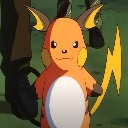

Predictions on test_raichu.png: ['Raichu']
Class: Blastoise, Probability: 0.1400
Class: Bulbasaur, Probability: 0.1300
Class: Charizard, Probability: 0.1500
Class: Charmander, Probability: 0.0400
Class: Charmeleon, Probability: 0.0400
Class: Ivysaur, Probability: 0.0200
Class: Pikachu, Probability: 0.0300
Class: Raichu, Probability: 0.0600
Class: Squirtle, Probability: 0.2100
Class: Venusaur, Probability: 0.0400
Class: Wartortle, Probability: 0.1400
Squirtle 0.21


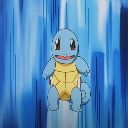

Predictions on test_squirtle.png: ['Squirtle']
Class: Blastoise, Probability: 0.0400
Class: Bulbasaur, Probability: 0.1100
Class: Charizard, Probability: 0.1000
Class: Charmander, Probability: 0.1000
Class: Charmeleon, Probability: 0.1500
Class: Ivysaur, Probability: 0.0800
Class: Pikachu, Probability: 0.1300
Class: Raichu, Probability: 0.0900
Class: Squirtle, Probability: 0.1200
Class: Venusaur, Probability: 0.0600
Class: Wartortle, Probability: 0.0200
Charmeleon 0.15


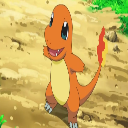

Predictions on test_charmander.png: ['Charmeleon']


In [71]:
# Example usage
detector = PokemonDetector(model_name='rforest')

print("Predictions on test_raichu.png:", detector.predict("manual-test-images/test_raichu.png"))
print("Predictions on test_squirtle.png:", detector.predict("manual-test-images/test_squirtle.png"))
print("Predictions on test_charmander.png:", detector.predict("manual-test-images/test_charmander.png"))

In [72]:
if USE_TRAIN:
    # ======================
    # Binary Classification
    # ======================
    print("\nTraining binary classifier...")
    X_bin = [fe.extract_all_features(img) for img in tqdm(pokemon_images + no_pokemon_images)]
    y_bin = [1] * len(pokemon_images) + [0] * len(no_pokemon_images)
        
    X_bin = fe.scaler_bin.fit_transform(X_bin)
    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_bin, y_bin, test_size=0.2, stratify=y_bin, random_state=42)
        
    #print(f"Train -> no-pokemon: {y_train_bin.count(0)}, pokemon: {y_train_bin.count(1)}")
    #print(f"Test -> no-pokemon: {y_test_bin.count(0)}, pokemon: {y_test_bin.count(1)}")
    #exit()

    pca_bin = None
    if USE_PCA:
        pca_bin = PCA(n_components=0.95, random_state=42)
        X_train_bin = pca_bin.fit_transform(X_train_bin)
        X_test_bin = pca_bin.transform(X_test_bin)
        joblib.dump(pca_bin, os.path.join(MODEL_SAVE_DIR, 'pca_bin.pkl'))

In [73]:
if USE_TRAIN:
    if DO_HYPERPARAMETER_TUNING:
        print("\nTuning binary classifier...")
        param_grid_bin = {
            'n_estimators': [100, 150, 200],
            'max_depth': [None, 10, 20]
        }
        grid_bin = GridSearchCV(
            RandomForestClassifier(random_state=42, class_weight='balanced'),
            param_grid_bin, cv=3, scoring='accuracy', n_jobs=2, verbose=2
        )
        grid_bin.fit(X_train_bin, y_train_bin)
        print("Best parameters for binary classifier:", grid_bin.best_params_)
        binary_clf = grid_bin.best_estimator_
    else:
        binary_clf = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced')
        binary_clf.fit(X_train_bin, y_train_bin)
        
    y_pred_bin = binary_clf.predict(X_test_bin)
    print("Binary Classifier Performance:")
    print(classification_report(y_test_bin, y_pred_bin))
    joblib.dump(binary_clf, os.path.join(MODEL_SAVE_DIR, 'binary_clf.pkl'))
        
    # Clean unused data
    del X_bin, y_bin, X_train_bin, X_test_bin, y_train_bin, y_test_bin
    del y_pred_bin
    if DO_HYPERPARAMETER_TUNING:
        del grid_bin
    gc.collect()

    joblib.dump(fe.scaler_bin, os.path.join(MODEL_SAVE_DIR, 'scaler_bin.pkl'))

In [74]:
# ======================
# Segmentation
# ======================
def recursive_tiling(image, depth=0, min_size=SEGMENT_MIN_SIZE, current_tiles=None):
    """Recursively splits image into quadrants while keeping all segments"""
    if current_tiles is None:
        current_tiles = []
    
    current_tiles.append(image)
    
    if depth >= MAX_RECURSION_DEPTH or image.shape[0] <= min_size or image.shape[1] <= min_size:
        return current_tiles
    
    half_h = image.shape[0] // 2
    half_w = image.shape[1] // 2
    
    recursive_tiling(image[:half_h, :half_w], depth+1, min_size, current_tiles)
    recursive_tiling(image[:half_h, half_w:], depth+1, min_size, current_tiles)
    recursive_tiling(image[half_h:, :half_w], depth+1, min_size, current_tiles)
    recursive_tiling(image[half_h:, half_w:], depth+1, min_size, current_tiles)
    
    return current_tiles

def filter_positive_tiles(tiles, classifier, feature_extractor, scaler, pca=None):
    """Filter tiles using binary classifier; apply PCA if provided"""
    positive_tiles = []
    for tile in tiles:
        resized = cv2.resize(tile, TARGET_SIZE) if tile.shape[:2] != TARGET_SIZE else tile
        resized = transform_image(resized)
        features = feature_extractor.extract_all_features(resized)
        features = scaler.transform([features])
        if pca is not None:
            features = pca.transform(features)
        if classifier.predict(features)[0] == 1:
            positive_tiles.append(tile)
    return positive_tiles

In [75]:
print("Predictions on test_image0.png:", detector.predict_multi('manual-test-images/test_image0.png', filter_positive_tiles, recursive_tiling))
print("Predictions on test_image1.png:", detector.predict_multi('manual-test-images/test_image1.png', filter_positive_tiles, recursive_tiling))
print("Predictions on test_image2.png:", detector.predict_multi('manual-test-images/test_image2.png', filter_positive_tiles, recursive_tiling))
print("Predictions on test_image3.png:", detector.predict_multi('manual-test-images/test_image3.png', filter_positive_tiles, recursive_tiling))
print("Predictions on test_image4.png:", detector.predict_multi('manual-test-images/test_image4.png', filter_positive_tiles, recursive_tiling))
print("Predictions on test_image5.png:", detector.predict_multi('manual-test-images/test_image5.png', filter_positive_tiles, recursive_tiling))
print("Predictions on test_bulb_pika.png:", detector.predict_multi('manual-test-images/test_bulb_pika.png', filter_positive_tiles, recursive_tiling))

Predictions on test_image0.png: ['Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle', 'Raichu', 'Ivysaur']
Predictions on test_image1.png: ['Charmander', 'Pikachu', 'Charmeleon', 'Bulbasaur', 'Squirtle', 'Raichu', 'Wartortle']
Predictions on test_image2.png: ['Bulbasaur', 'Ivysaur']
Predictions on test_image3.png: ['Blastoise', 'Raichu', 'Ivysaur']
Predictions on test_image4.png: ['Charmander', 'Charmeleon', 'Bulbasaur', 'Squirtle', 'Ivysaur', 'Charizard', 'Blastoise', 'Venusaur', 'Wartortle']
Predictions on test_image5.png: ['Venusaur', 'Raichu', 'Ivysaur', 'Charizard']
Predictions on test_bulb_pika.png: ['Blastoise', 'Bulbasaur', 'Venusaur', 'Ivysaur']
